# Calibration of probabilistic forecasting intervals

When using probabilistic forecasting methods, it is often necessary to estimate prediction intervals for the forecasted values. Prediction intervals quantify the uncertainty in forecasts and allow one to assess the probability that the actual value will fall within the predicted range. One of the most commonly used methods for calibrating prediction intervals is the conformal prediction framework.

Conformal prediction is a framework for constructing prediction intervals that are guaranteed to contain the true value with a specified probability (coverage probability). In addition to generating prediction intervals from point forecasts, conformal methods can also calibrate intervals produced by other techniques, such as quantile regression or bootstrapped residuals. In such cases, the conformal method adjusts the intervals—either expanding or shrinking them—to ensure they achieve the desired coverage.

<p style="text-align: center">
    <img src="../img/conformal-interval-calibration.png" style="width: 450px">
    <br>
    <font size="2.5"> 
        <i>
        Conformal calibration of prediction intervals. Source: 
            <a href="https://leanpub.com/conformal-prediction" target="_blank"> 
                Introduction To Conformal Prediction With Python: A Short Guide For Quantifying Uncertainty Of Machine Learning Models 
            </a> 
        by Christoph Molnar
        </i>
    </font>
</p>

Skforecast provides this functionality through the [`ConformalIntervalCalibrator`](../api/preprocessing.html#skforecast.preprocessing.preprocessing.ConformalIntervalCalibrator) transformer that can be used for single series forecasting models as well as global forecasting models.

<div class="admonition note" name="html-admonition" style="background: rgba(0,191,191,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #00bfa5; border-color: #00bfa5; padding-left: 10px; padding-right: 10px;">

<p class="title">
    <i style="font-size: 18px; color:#00bfa5;"></i>
    <b style="color: #00bfa5;">&#128161 Tip</b>
</p>

<p>

This document demonstrates how <code>ConformalIntervalCalibrator</code> can improve various types of prediction intervals —whether overly conservative or under-conservative— using both symmetric and asymmetric conformal calibration. In these examples, the transformer is fitted and applied to the same dataset. However, in forecasting problems, the transformer should be fitted using a calibration set and then applied to the prediction intervals of the forecast set.

This document demonstrates how the <code>ConformalIntervalCalibrator</code> can improve various types of prediction intervals - whether overly conservative or underly conservative - using both symmetric and asymmetric conformal calibration. In these examples, the calibrator is fitted and applied to the same dataset. In real scenario problems, however, the transformer should be fitted using a calibration set and then applied to the prediction intervals of the test set.

</p>
</div>

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.plot import set_dark_theme
from skforecast.metrics import calculate_coverage
from skforecast.preprocessing import ConformalIntervalCalibrator

# Symmetric calibration

In symmetric calibration, prediction intervals are expanded or contracted by a constant factor to ensure that the coverage probability is achieved. This means that both the upper and lower prediction intervals are adjusted by the same factor.

### Under-conservative intervals

Underconservative intervals (optimistic intervals) have a lower than desired coverage probability, meaning they are too narrow and exclude the true value too often. In this case, conformal calibration expands the intervals to increase the coverage.

Coverage: 0.67


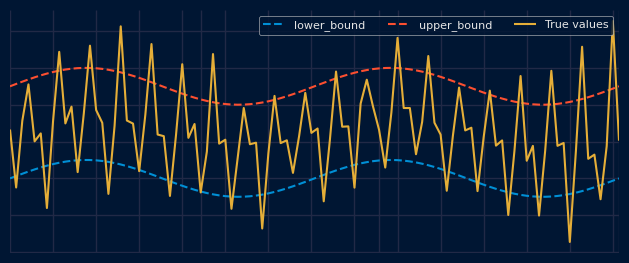

In [ ]:
# Simulation of interval
# ==============================================================================
rng = np.random.default_rng(42)
interval = pd.DataFrame({
        'lower_bound': np.sin(np.linspace(0, 4 * np.pi, 100)),
        'upper_bound': np.sin(np.linspace(0, 4 * np.pi, 100)) + 5
    },
    index=pd.date_range(start='2024-01-01', periods=100, freq='D')
)
y_true = (interval['lower_bound'] + interval['upper_bound']) / 2 + rng.normal(0, 0.5, 100)
y_true.name = "series_1"
y_true.iloc[1::5] = interval.iloc[1::5, 0] - rng.normal(1, 1, 20)
y_true.iloc[3::5] = interval.iloc[1::5, 1] + rng.normal(1, 1, 20)

set_dark_theme()
fig, ax = plt.subplots(figsize=(7, 3))
interval.plot(ax=ax, linestyle="--")
y_true.plot(ax=ax, label='True values')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(loc="upper right", fontsize=8, ncol=3)
plt.show()

coverage = calculate_coverage(
    y_true=y_true,
    lower_bound=interval["lower_bound"],
    upper_bound=interval["upper_bound"],
)
print(f'Coverage: {coverage:.2f}')

ConformalIntervalCalibrator 
Nominal coverage: 0.8 
Coverage in fit data: {'series_1': 0.67} 
Symmetric interval: False 
Symmetric correction factor: {'series_1': 0.9488126715432241} 
Asymmetric correction factor lower: {'series_1': 0.7640361794875151} 
Asymmetric correction factor upper: {'series_1': 1.0384612609432264} 
Fitted series: ['series_1'] 

Coverage after calibration: 0.80


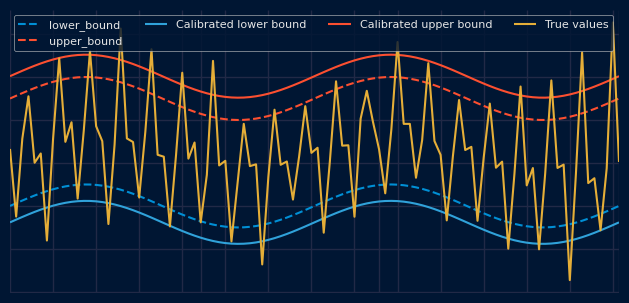

In [ ]:
# Calibrate interval
# ==============================================================================
calibrator = ConformalIntervalCalibrator(nominal_coverage=0.8, symmetric_calibration=False)
calibrator.fit(y_true=y_true, y_pred_interval=interval)
print(calibrator)

interval_calibrated = calibrator.transform(interval)
fig, ax = plt.subplots(figsize=(7, 3.5))
interval.plot(ax=ax, linestyle="--")
interval_calibrated["lower_bound"].plot(ax=ax, color="#30a2da", label="Calibrated lower bound")
interval_calibrated["upper_bound"].plot(ax=ax, color="#fc4f30", label="Calibrated upper bound")
y_true.plot(ax=ax, label="True values")
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(loc="upper right", fontsize=8, ncol=4)
plt.show()

coverage = calculate_coverage(
               y_true      = y_true,
               lower_bound = interval_calibrated["lower_bound"],
               upper_bound = interval_calibrated["upper_bound"],
           )
print(f"Coverage after calibration: {coverage:.2f}")

The interval has been expanded by a factor of 0.948 in both directions, achieving a coverage probability of 0.80.

### Over-conservative intervals

Overly conservative intervals (pessimistic intervals) have a higher than desired coverage probability, meaning they are too wide and include the true value too often. In this case, the conformal calibration shrinks the intervals to reduce the coverage. 

To illustrate, the initial interval has a coverage probability of 80% and the desired coverage probability is 70%.

Coverage: 0.80


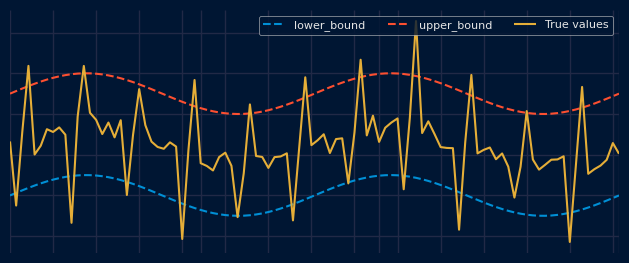

In [ ]:
# Simulation of interval
# ==============================================================================
rng = np.random.default_rng(42)
interval = pd.DataFrame({
        'lower_bound': np.sin(np.linspace(0, 4 * np.pi, 100)),
        'upper_bound': np.sin(np.linspace(0, 4 * np.pi, 100)) + 5
    },
    index=pd.date_range(start='2024-01-01', periods=100, freq='D')
)
y_true = (interval['lower_bound'] + interval['upper_bound']) / 2 + rng.normal(0, 0.5, 100)
y_true.name = "series_1"
y_true.iloc[1::9] = interval.iloc[1::9, 0] - rng.normal(1, 1, 11)
y_true.iloc[3::9] = interval.iloc[1::9, 1] + rng.normal(1, 1, 11)

fig, ax = plt.subplots(figsize=(7, 3))
interval.plot(ax=ax, linestyle="--")
y_true.plot(ax=ax, label='True values')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(loc="upper right", fontsize=8, ncol=3)
plt.show()

coverage = calculate_coverage(
               y_true      = y_true,
               lower_bound = interval["lower_bound"],
               upper_bound = interval["upper_bound"],
           )
print(f'Coverage: {coverage:.2f}')

ConformalIntervalCalibrator 
Nominal coverage: 0.7 
Coverage in fit data: {'series_1': 0.8} 
Symmetric interval: False 
Symmetric correction factor: {'series_1': -1.8807575829634011} 
Asymmetric correction factor lower: {'series_1': -1.775690512731013} 
Asymmetric correction factor upper: {'series_1': -2.0540377453500485} 
Fitted series: ['series_1'] 

Coverage after calibration: 0.70


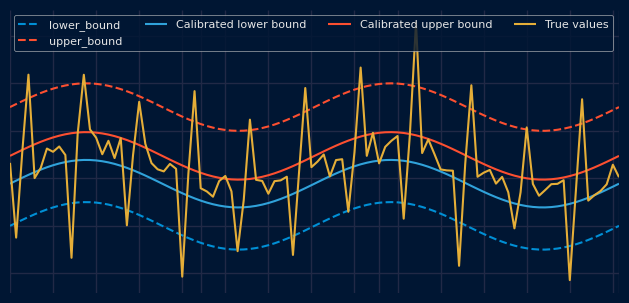

In [ ]:
# Calibrate interval
# ==============================================================================
calibrator = ConformalIntervalCalibrator(nominal_coverage=0.7, symmetric_calibration=False)
calibrator.fit(y_true=y_true, y_pred_interval=interval)
print(calibrator)
interval_calibrated = calibrator.transform(interval)
fig, ax = plt.subplots(figsize=(7, 3.5))
interval.plot(ax=ax, linestyle="--")
interval_calibrated["lower_bound"].plot(ax=ax, color="#30a2da", label="Calibrated lower bound")
interval_calibrated["upper_bound"].plot(ax=ax, color="#fc4f30", label="Calibrated upper bound")
y_true.plot(ax=ax, label="True values")
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(loc="upper right", fontsize=8, ncol=4)
plt.show()

coverage = calculate_coverage(
               y_true      = y_true,
               lower_bound = interval_calibrated["lower_bound"],
               upper_bound = interval_calibrated["upper_bound"],
           )
print(f"Coverage after calibration: {coverage:.2f}")

The resulting interval has been shrunk by a factor of 1.88 in both directions, achieving a coverage probability of 0.70.

# Asymetric calibration

Asymmetric calibration allows the upper and lower prediction intervals to be adjusted by different factors. This is useful when the prediction intervals are not symmetrically distributed around the point forecast.

Coverage: 0.66


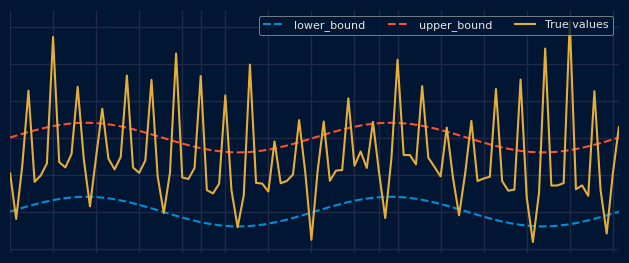

In [ ]:
# Simulation of interval
# ==============================================================================
rng = np.random.default_rng(42)
interval = pd.DataFrame({
        'lower_bound': np.sin(np.linspace(0, 4 * np.pi, 100)),
        'upper_bound': np.sin(np.linspace(0, 4 * np.pi, 100)) + 5
    },
    index=pd.date_range(start='2024-01-01', periods=100, freq='D')
)
y_true = (interval['lower_bound'] + interval['upper_bound']) / 2 + rng.normal(0, 0.5, 100)
y_true.name = "series_1"
y_true.iloc[1::6] = interval.iloc[1::6, 0] - rng.normal(1, 1, 17)
y_true.iloc[3::4] = interval.iloc[1::4, 1] + rng.normal(3, 2, 25)

fig, ax = plt.subplots(figsize=(7, 3))
interval.plot(ax=ax, linestyle="--")
y_true.plot(ax=ax, label='True values')
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(loc="upper right", fontsize=8, ncol=3)
plt.show()

coverage = calculate_coverage(
               y_true      = y_true,
               lower_bound = interval["lower_bound"],
               upper_bound = interval["upper_bound"],
           )
print(f'Coverage: {coverage:.2f}')

The plot shows that there are more points above the prediction interval than below it. Also, the points above the interval are farther away than the points below the lower interval. This suggests that the upper interval should be expanded more than the lower interval.

ConformalIntervalCalibrator 
Nominal coverage: 0.8 
Coverage in fit data: {'series_1': 0.66} 
Symmetric interval: False 
Symmetric correction factor: {'series_1': 1.2730256977929353} 
Asymmetric correction factor lower: {'series_1': -1.6431477452861944} 
Asymmetric correction factor upper: {'series_1': 3.691274308503413} 
Fitted series: ['series_1'] 

Coverage after calibration: 0.80


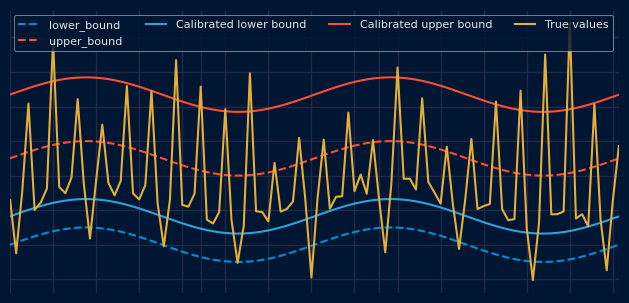

In [ ]:
# Calibrate interval
# ==============================================================================
calibrator = ConformalIntervalCalibrator(nominal_coverage=0.8, symmetric_calibration=False)
calibrator.fit(y_true=y_true, y_pred_interval=interval)
print(calibrator)
interval_calibrated = calibrator.transform(interval)
fig, ax = plt.subplots(figsize=(7, 3.5))
interval.plot(ax=ax, linestyle="--")
interval_calibrated["lower_bound"].plot(ax=ax, color="#30a2da", label="Calibrated lower bound")
interval_calibrated["upper_bound"].plot(ax=ax, color="#fc4f30", label="Calibrated upper bound")
y_true.plot(ax=ax, label="True values")
ax.set_yticklabels([])
ax.set_xticklabels([])
ax.legend(loc="upper right", fontsize=8, ncol=4)
plt.show()

coverage = calculate_coverage(
               y_true      = y_true,
               lower_bound = interval_calibrated["lower_bound"],
               upper_bound = interval_calibrated["upper_bound"],
           )
print(f"Coverage after calibration: {coverage:.2f}")

The asymmetric calibration has expanded the upper interval by a factor of 3.69 while shrinking the lower interval by a factor of 1.64.

The positive correction factor for the upper interval indicates that more points fall above the interval than expected for an upper limit representing the 0.90 quantile. To correct this, the interval is expanded, reducing the number of points that exceed the upper bound.

Conversely, the negative correction factor for the lower interval suggests that fewer points fall below the interval than expected for a lower limit representing the 0.10 quantile. As a result, the interval is shrunk to ensure that more points fall below the lower bound.

The reason the upper and lower bounds correspond to the 0.90 and 0.10 quantiles, respectively, is that the desired coverage probability is 80%. Internally, the transformer assumes that the upper bound should represent the quantile $(1 - \frac{(1 - 0.8)}{2})$ and the lower bound should represent the quantile $(\frac{(1 - 0.8)}{2})$.